In [1]:
# Insert path to where you extract the mcgillthz folder to use the package anywhere
import sys 
sys.path.insert(1,"C:/Users/Rodrigo/OneDrive - McGill University/5. Software/mcgillthz") #Insert path to mcgillthz folder

from mcgillthz import *

# For iterative plots
# %matplotlib widget 

# For simple inline plots
%matplotlib inline 

This is a tutorial for the extraction of the optical reponse functions numerically using the functions contained in the "cookethz" package. Although a full documentation of the code is not available, the functions are thoroughly described where they are defined. The files that contain all the functions are:

- fft_utils.py - All Fourier transform related functions, including padding, wavelet transforms and more.
- import_utils.py - Functions to easily import experimental data, including error estimation and averaging.
- utils.py - Contains miscellaneous functions like a function to do Hilbert transform, calculate the Carrier Envelope phase (CEP) and to convert between response functions. Also includes physical constants
- tds_analysis.py - All functions needed for time-domain spectroscopy, from determining the amplitude and phase of the transmission coefficiet, to numerically find the complex refractive index.
- basic_plots.py - Basic functions to do standard plots quickly.

# Silicon

## Import files

Let's import the files without any parameters and plot them.

We'll use the import_file( ) function. If multiple averages were taken, import_files( ) could be used instead to give an error estimate.

c:\Users\Rodrigo\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Rodrigo\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


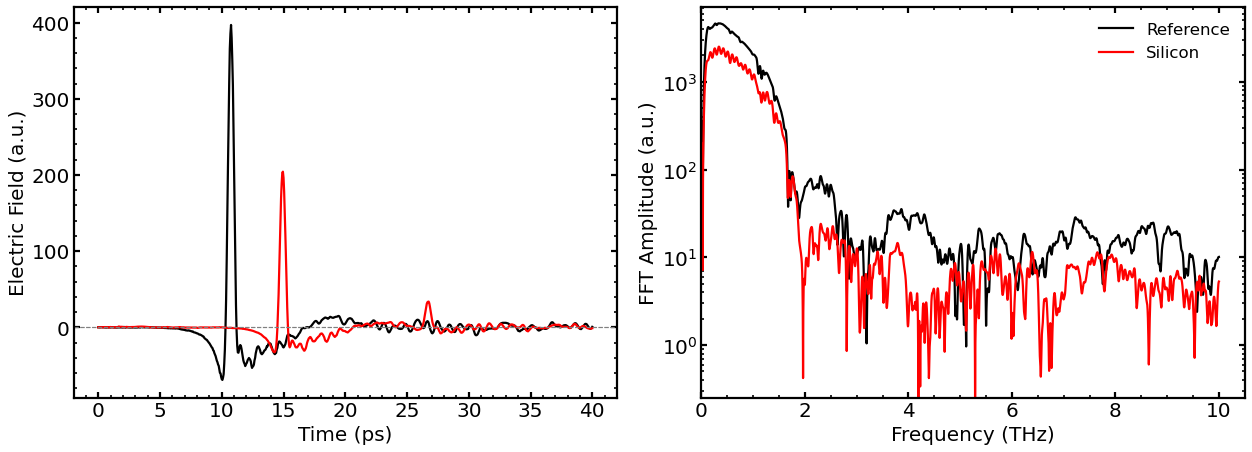

In [2]:

file = './data/Silicon-ref.DAT'
ref_td, ref_fft = import_file(file)

file = './data/Silicon.DAT'
si_td, si_fft = import_file(file)

axs = plot_spectrum(ref_td, ref_fft, color='black', label='Reference')
axs = plot_spectrum(si_td, si_fft, color='red', label='Silicon', axs=axs)


Now we can re-import them, setting the appropriate parameters. 

max_time=25 removes the Fabry-Perot reflection. Taking it into account is possible when defining the transfer function, but requires very precise determination of the sample thickness.

max_t_bg=5 will consider that everything before 5 ps is experimental background, and will subtract that value.

You can also choose another type of FFT window. Examples that work well are "hann", "blackman", "hamming", etc.

The max_freq parameter in plot_spectrum sets the frequency at which to start calculating the RMS background, plot as a horizontal solid line.

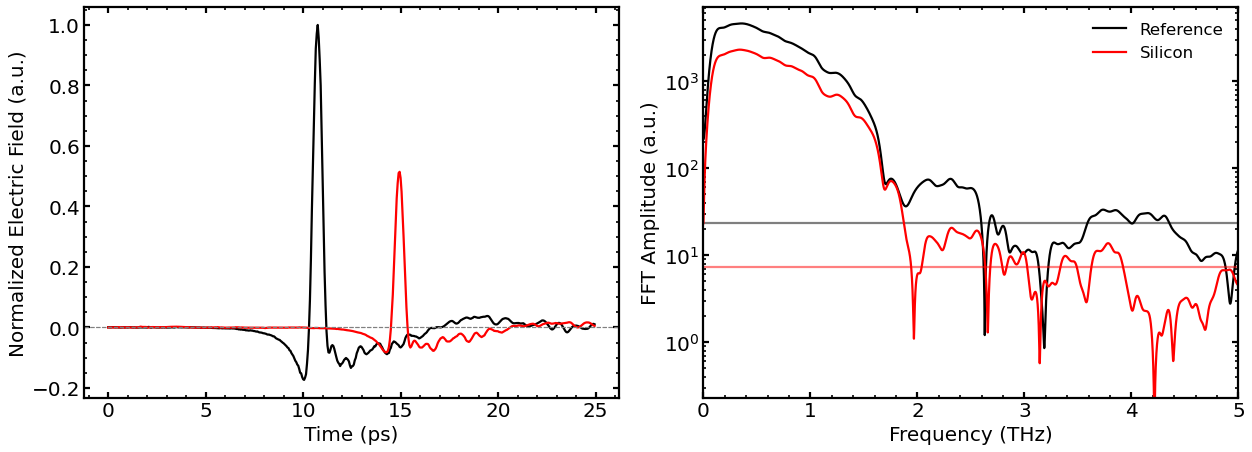

In [3]:

file = './data/Silicon-ref.DAT'
ref_td, ref_fft = import_file(file, normalize=1, max_time=25, max_t_bg=5, window='hann')

file = './data/Silicon.DAT'
si_td, si_fft = import_file(file, normalize=1, max_time=25, max_t_bg=10, window='hann')

axs, norm = plot_spectrum(ref_td, ref_fft, color='black', label='Reference', normalize=0, max_freq=2)
axs = plot_spectrum(si_td, si_fft, color='red', label='Silicon', axs=axs, normalize=norm, max_freq=2)

axs[1].set_xlim(0, 5)

plt.show()

## Get transmission

We use the get_T function to calculate the transmission amplitude and phase. The phase unwrapping is performed as described in Peter Jepsen's "Phase Retrieval in THz Time-Domain Measurements: a how to Tutorial".

The freqs_for_fit has to be set in a frequency range without many absorptions. A line will be fitted in this region to subtract any offsets multiple of 2 $\pi$.

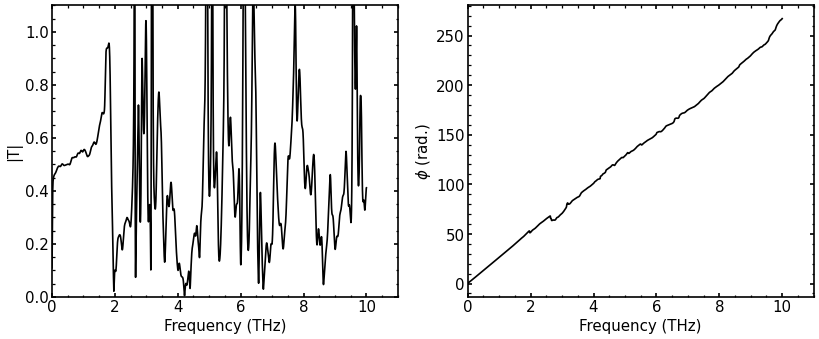

In [4]:
T_Si = get_T(ref_td, ref_fft, si_td, si_fft, freqs_for_fit=[0.4, 1])


axs = plot_transmission(T_Si)

We can plot it without the offset from the time displacement. The phase should be close to 0 without absorptions.

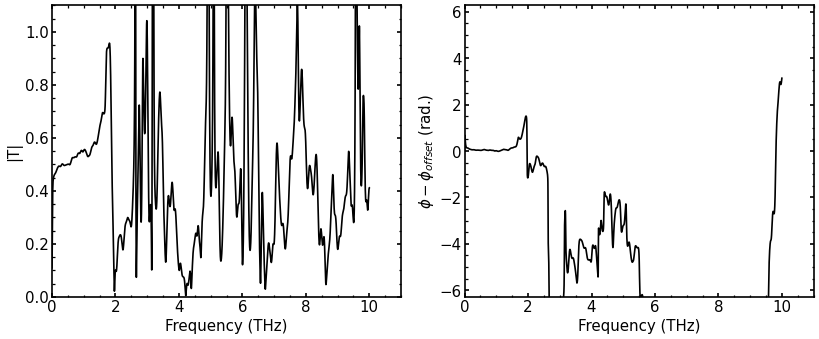

In [5]:
T_Si = get_T(ref_td, ref_fft, si_td, si_fft, freqs_for_fit=[0.4, 1])



delta_t = si_td[0][np.argmax(si_td[1])] - ref_td[0][np.argmax(ref_td[1])]

axs = plot_transmission(T_Si, delta_t=delta_t)


## Define the transmission function

This experiment was performed as follows

$$\text{Reference: } E_{in} \Rightarrow \text{air}(d) \Rightarrow E_{ref}$$


$$\text{Sample: } E_{in} \Rightarrow \text{Si}(d) \Rightarrow E_{samp}$$

This means we can write

$$ E_{ref} = P_{n_0} (d) E_{in} $$

$$ E_{samp} = t_{n_0, \tilde{n}} P_{\tilde{n}}(d) t_{\tilde{n}, n_0} E_{in} $$

Here, $n_0$ is the refractive index of the air and $\tilde{n}$ is the refractice index of the sample, that we want to find out. The complex Fresnel coefficient for the transmission of an electric field normal to a surface $t_{n_1, n_2}$ is

$$ t_{n_1, n_2} = \frac{2 n_1}{n_1 + n_2} $$

, and $P_{n_1}(d)$ represents the propagation of plane wave within a material of index $n$ for a distance $d$, represented as

$$ P_{n_1}(d) = e^{i \omega d n_1 / c} .$$

The transmission function, in this case, is simply

$$ T = \frac{E_{samp}}{E_{ref}} = \frac{t_{n_0, \tilde{n}} P_{\tilde{n}}(d) t_{\tilde{n}, n_0} }{P_{n_0}(d)}$$


When you define it, the function must have the complex refractive index to be found as the first parameter, the frequency as the second, and as many fixed parameters as needed afterwards.

The function must return the amplitude, and the phase separately.


In [6]:
def T_function(n_til, freq, d, n0):
    """
    n_til will be the fitted parameter, so it is the unknown refractive index
    freq must be the second parameter, the frequencies in THz
    d, nd are fixed paremeters specific to this experiment

    The function must return the amplitude and phase separatelly, but any transfer function can be used.
    """
    k = 2*np.pi*(freq * 1e12)/c # Defines the vacuum wavenumber in Si units

    t01 = 2 * n0 / (n_til + n0)
    P1 = np.exp(1j * k * d * n_til)
    t10 = 2 * n_til / (n_til + n0)

    P2 = np.exp(1j * k * d * n0)

    amp = np.abs(t01 * P1 * t10 / P2 )  # np.abs( ) get's the absolute value
    # np.angle( ) returns the phase of a complex number between -2pi and +2pi, so we add then individually. 
    # We calculate the phase from propagating terms manually to avoid the limits of np.angle() as well.
    phase = np.angle(t01) + np.angle(t10) + (k*d*np.real(n_til)) - (k*d*np.real(n0))    

    return amp, phase

## Fit the transmission

Now we define the frequencies at which to calculate the refractive index, give an initial guess, and call the function minimize_err( ) to find the complex refractive index.

Make sure the frequencies you select include only regions where you have a decent THz amplitude.

In [7]:
n0 = 1
d_Si = 520e-6

freqs_Si = np.arange(.05, 1.7, .005)

n_guess = 3 + 1j * 1e-3

n_Si = minimize_err(n_guess, freqs_Si, T_function, [d_Si, n0], T_Si[0], T_Si[1], T_Si[2], method='L-BFGS-B')

R2_Si = get_R2(n_Si, freqs_Si, T_function, [d_Si, n0], T_Si[0], T_Si[1], T_Si[2])

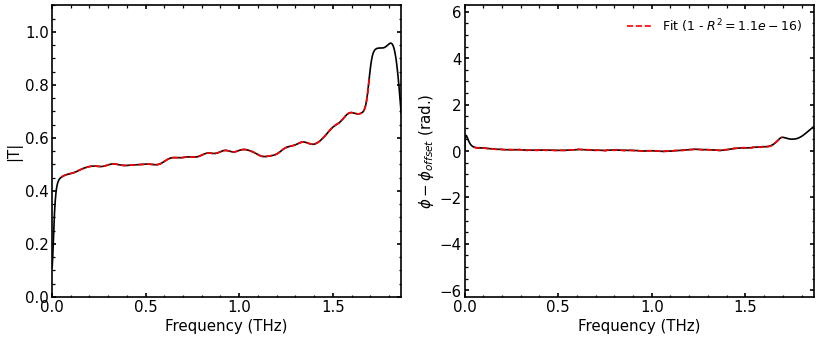

In [8]:

delta_t = si_td[0][np.argmax(si_td[1])] - ref_td[0][np.argmax(ref_td[1])]

axs = plot_transmission(T_Si, delta_t=delta_t, color='black', linestyle='-')

Amp, phase = T_function(n_Si, freqs_Si, d_Si, n0)

axs = plot_transmission([freqs_Si, Amp, phase], delta_t=delta_t, axs=axs, color='red', linestyle='--', label=f'Fit (1 - $R^2 = {1-R2_Si:.1e}$)')


If the model lines match the experimental lines, we have a succesfull fit! If not, try changing the optimization method, the frequency range (sometimes a finer grid is needed when there is absorption), or start the fit from low frequencies first (set start_from_low=True)

## Plot response functions

The plot_n_til() readily plots the complex refractive index. The absorb=True tag transforms the extinction coefficient $\kappa$ into the absorbtion coefficient in (cm-1)

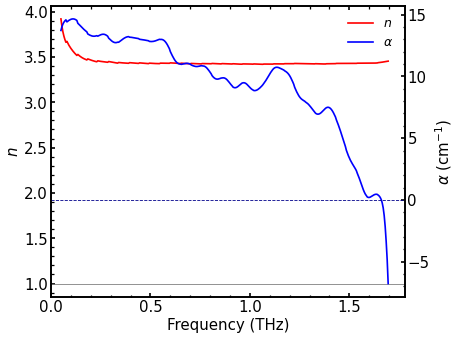

In [9]:
ax = plot_n_til(freqs_Si, n_Si, absorb=True)

We can calculate the dielectric constant and the conductivity easily.

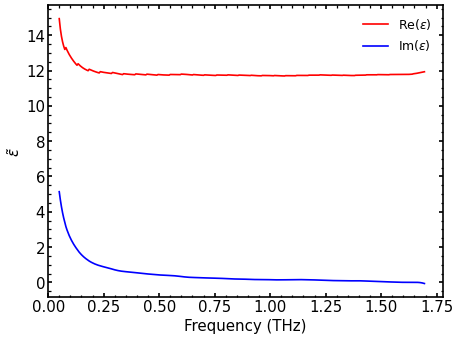

In [10]:
eps_Si = eps_from_n(n_Si)

ax = plot_eps(freqs_Si, eps_Si)

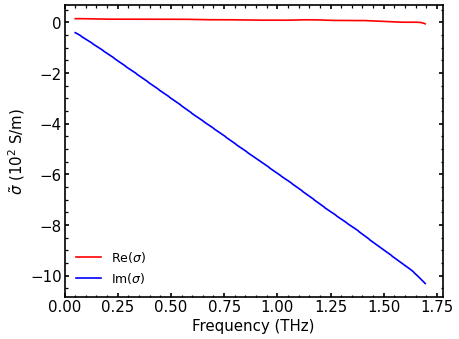

In [11]:
sig_Si = sig_from_n(n_Si, freqs_Si)

ax = plot_sigma(freqs_Si, sig_Si, norm=1e2)

# Lactose

Now let's do the same with lactose. Lactose has very strong THz absorption, so the fit is significantly harder.

## Import files

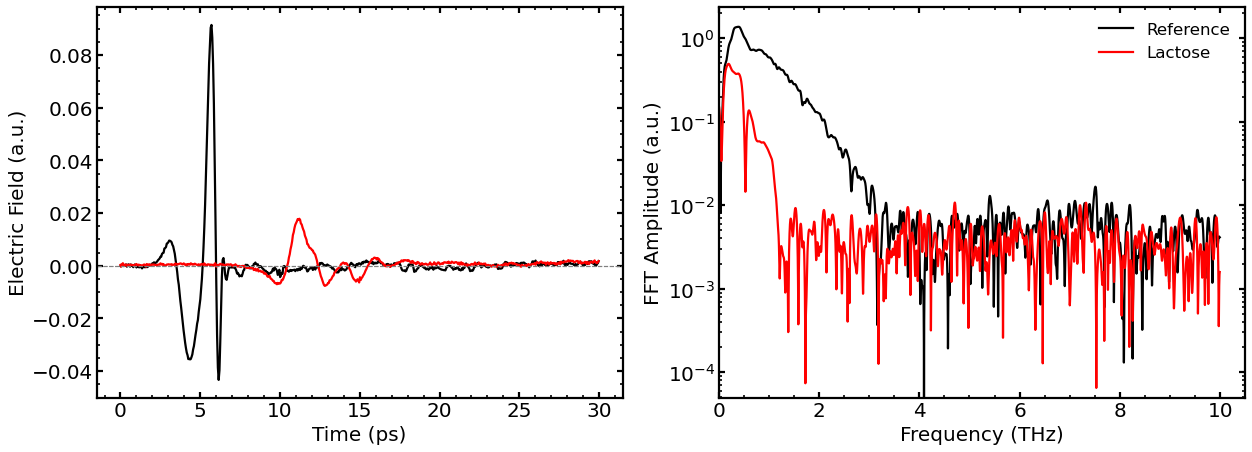

In [12]:
file = './data/Lactose-Ref.DAT'
ref_td, ref_fft = import_file(file)

file = './data/Lactose.DAT'
lac_td, lac_fft = import_file(file)

axs = plot_spectrum(ref_td, ref_fft, color='black', label='Reference')
axs = plot_spectrum(lac_td, lac_fft, color='red', label='Lactose', axs=axs)


(0.0, 4.0)

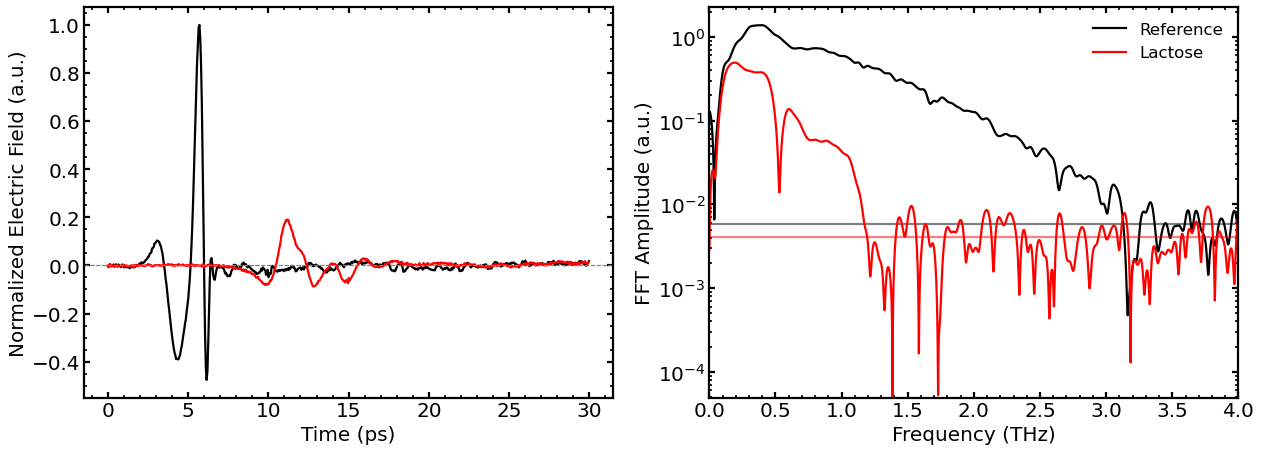

In [13]:
file = './data/Lactose-Ref.DAT'
ref_td, ref_fft = import_file(file, max_t_bg=0.6)

file = './data/Lactose.DAT'
lac_td, lac_fft = import_file(file, max_t_bg=5)

axs, norm = plot_spectrum(ref_td, ref_fft, color='black', label='Reference', normalize=0, max_freq=4)
axs = plot_spectrum(lac_td, lac_fft, color='red', label='Lactose', axs=axs, normalize=norm, max_freq=4)

axs[1].set_xlim(right=4)


## Get transmission

Here, care must be taken in selecting the freqs_for_fit range

(0.0, 5.0)

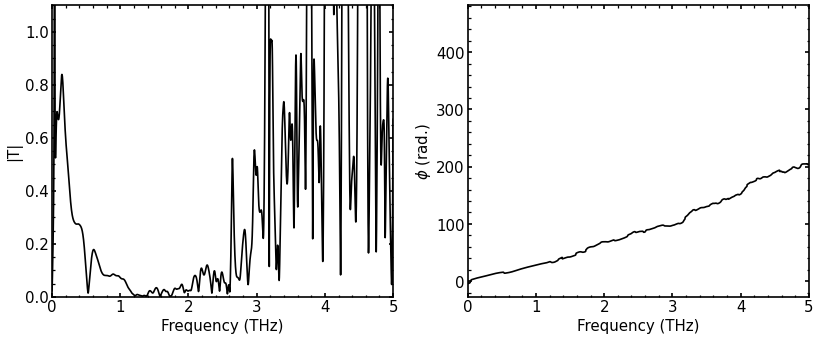

In [14]:
T_lac = get_T(ref_td, ref_fft, lac_td, lac_fft, freqs_for_fit=[0.1, .3])


axs = plot_transmission(T_lac)

axs[0].set_xlim(0,5)

(-10.0, 10.0)

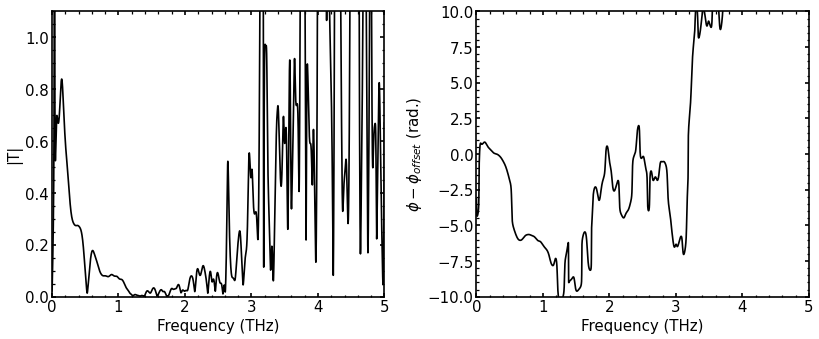

In [15]:


delta_t = lac_td[0][np.argmax(lac_td[1])] - ref_td[0][np.argmax(ref_td[1])]

axs = plot_transmission(T_lac, delta_t=delta_t)

axs[0].set_xlim(0,5)
axs[1].set_ylim(-10, 10)


## Define transmission function

This experiment is the same as the previous one. Either going through the sample or going through air.

In [16]:
def T_function(n_til, freq, d, n0):
    """
    n_til will be the fitted parameter, so it is the unknown refractive index
    freq must be the second parameter, the frequencies in THz
    d, nd are fixed paremeters specific to this experiment

    The function must return the amplitude and phase separatelly, but any transfer function can be used.
    """
    k = 2*np.pi*(freq * 1e12)/c # Defines the vacuum wavenumber in Si units

    t01 = 2 * n0 / (n_til + n0)
    P1 = np.exp(1j * k * d * n_til)
    t10 = 2 * n_til / (n_til + n0)

    P2 = np.exp(1j * k * d * n0)

    amp = np.abs(t01 * P1 * t10 / P2 )  # np.abs( ) get's the absolute value
    # np.angle( ) returns the phase of a complex number between -2pi and +2pi, so we add then individually. 
    # We calculate the phase from propagating terms manually to avoid the limits of np.angle() as well.
    phase = np.angle(t01) + np.angle(t10) + (k*d*np.real(n_til)) - (k*d*np.real(n0))    

    return amp, phase

## Fit transmission

Due to sharp absorptions, the frequency spacing must be reduced to acquire a good fit.

In [17]:
n0 = 1
d_lac = 2e-3

freqs_lac = np.arange(.05, 3, .005)

n_guess = 1 + 0j * 1

n_lac = minimize_err(n_guess, freqs_lac, T_function, [d_lac, n0], T_lac[0], T_lac[1], T_lac[2], method='Nelder-Mead', start_from_low=True)

R2_lac = get_R2(n_lac, freqs_lac, T_function, [d_lac, n0], T_lac[0], T_lac[1], T_lac[2])

(-10.0, 10.0)

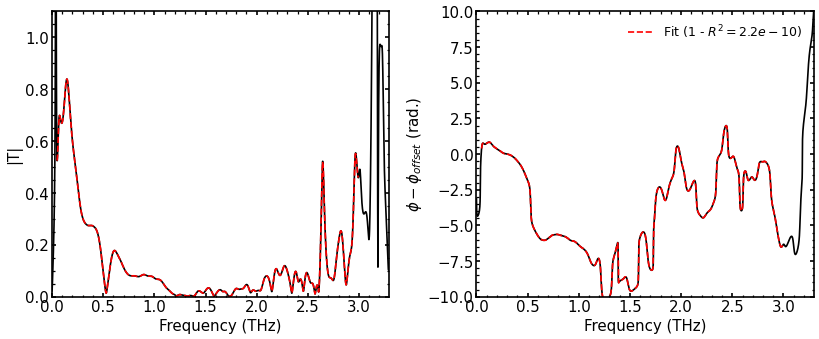

In [18]:


delta_t = lac_td[0][np.argmax(lac_td[1])] - ref_td[0][np.argmax(ref_td[1])]

axs = plot_transmission(T_lac, delta_t=delta_t, color='black', linestyle='-')

Amp, phase = T_function(n_lac, freqs_lac, d_lac, n0)

axs = plot_transmission([freqs_lac, Amp, phase], delta_t=delta_t, axs=axs, color='red', linestyle='--', label=f'Fit (1 - $R^2 = {1-R2_lac:.1e}$)')


axs[1].set_ylim(-10, 10)


## Plot response functions

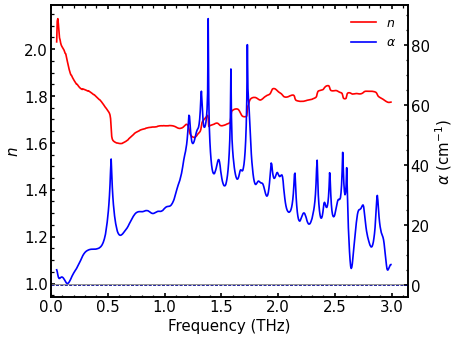

In [19]:
ax = plot_n_til(freqs_lac, n_lac, absorb=True)

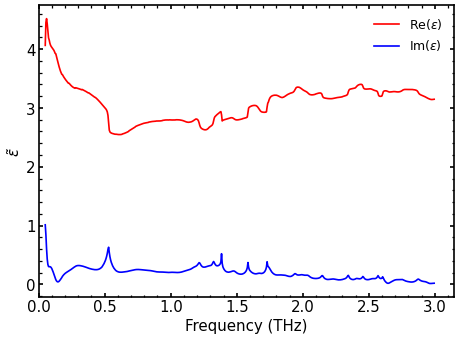

In [20]:
eps_lac = eps_from_n(n_lac)

ax = plot_eps(freqs_lac, eps_lac)

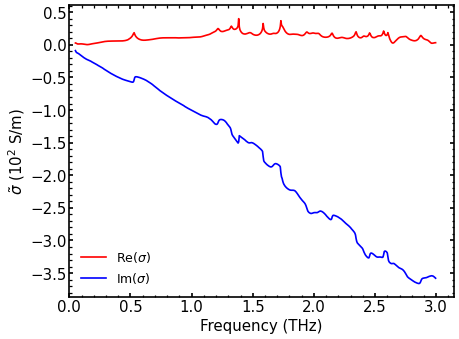

In [21]:
sig_lac = sig_from_n(n_lac, freqs_lac)

ax = plot_sigma(freqs_lac, sig_lac, norm=1e2)